# Eliciting User-Defined Mid-Air Hand Gestures for Hybrid Meeting Platform Control: Results, Insights, and Design Implications

This Jupyter notebook contains the code used to analyze the data collected from the user study described in the paper `Eliciting User-Defined Mid-Air Hand Gestures for Hybrid Meeting Platform Control: Results, Insights, and Design Implications`. It provides a comprehensive analysis of user-defined mid-air hand gestures collected for controlling a hybrid meeting platform. The workflow includes:

- **Data Loading and Preparation:** The dataset is loaded and preprocessed, including gesture descriptions, opposites, and command mappings.
- **Taxonomy Classification:** Gestures are classified according to multiple taxonomies (nature, locale, form, composition), with consensus and inter-rater agreement (Fleiss' Kappa) calculated and visualized.
- **Gesture Frequency Analysis:** The frequency of each gesture per command is computed and visualized to identify common patterns.
- **Agreement and Oppositeness:** Agreement rates among participants and the use of opposite gestures for paired commands are statistically analyzed.
- **Dissimilarity-Consensus:** The similarity of gesture embeddings is assessed using Dynamic Time Warping, quantifying consensus for each command.
- **Dimensionality Reduction and Visualization:** Linear Discriminant Analysis (LDA) is used to project gesture embeddings into 2D space, visualizing the distribution and clustering of gestures per command.

The notebook combines statistical analysis, visualization, and interpretability to derive insights and design implications for gesture-based interaction in hybrid meeting platforms.

## Setting Up the Environment for Statistical Analysis and Visualization

This section outlines the necessary libraries and packages required for the analysis. Ensure you have installed the Python environment:

```bash
conda env create --file=environment.yml
conda activate interact2025
poetry install
```

## Import Required Libraries

The following libraries are essential for data manipulation, statistical analysis, and visualization:

In [1]:
# Import necessary libraries.
from enum import Enum
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.stats import chi2
from sklearn.metrics import confusion_matrix
from statsmodels.stats.inter_rater import fleiss_kappa


# Set the style of the plots.
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family" : "serif",
    "font.size": 22,
    "font.serif":  "cmr10",
    "text.usetex": True,
    "pgf.rcfonts": False,
})
plt.rcParams["axes.formatter.use_mathtext"] = True

## Defining Gesture and Model Enums

This code cell defines two `Enum` classes, `Gesture` and `Models`, to represent the different hand gesture commands and LLM-based models used in the study. It also creates two dictionaries, `GESTURES_MAP` and `MODELS_MAP`, which map these enum values to human-readable strings for better interpretability in analysis and visualization. These mappings are used throughout the notebook to reference gesture commands and model names in a clear and consistent manner.

In [2]:
class Gesture(Enum):
    """Enum class to represent the different hand gestures."""
    C1_COMMAND = "c1_command"
    C2_COMMAND = "c2_command"
    C3_COMMAND = "c3_command"
    C4_COMMAND = "c4_command"
    C5_COMMAND = "c5_command"
    C6_COMMAND = "c6_command"
    C7_COMMAND = "c7_command"
    C8_COMMAND = "c8_command"

class Models(Enum):
    """Models class to represent the different LLM-based models."""
    OPENAI_MODEL = "openai"
    GEMINI_MODEL = "gemini"
    LLAMA_MODEL = "llama"

# Mappings for better readability.
GESTURES_MAP: Dict[Gesture, str] = {
    Gesture.C1_COMMAND: "Increase Volume",
    Gesture.C2_COMMAND: "Decrease Volume",
    Gesture.C3_COMMAND: "Mute Microphone",
    Gesture.C4_COMMAND: "Unmute Microphone",
    Gesture.C5_COMMAND: "Turn Off Camera",
    Gesture.C6_COMMAND: "Turn On Camera",
    Gesture.C7_COMMAND: "Ask for a Question",
    Gesture.C8_COMMAND: "End Call",
}

MODELS_MAP: Dict[Models, str] = {
    Models.OPENAI_MODEL: "GPT-4o",
    Models.GEMINI_MODEL: "Gemini",
    Models.LLAMA_MODEL: "Llama",
}

## Data Loading and Preparation

This code cell loads the primary datasets required for the analysis, including the original elicitation dataset, the opposite gesture mappings, and the hand gesture embeddings. It preprocesses the data by converting embedding strings to NumPy arrays and extracts relevant columns for subsequent analysis. This setup ensures that all necessary data structures are ready for gesture frequency analysis, agreement calculations, and further statistical processing.

In [3]:
# Read the original dataset.
datasets = [
    pd.read_csv("./dataset/elicit_cam.csv"),
    pd.read_csv("./dataset/opposite_gestures.csv"),
    pd.read_csv("./data/d0_hand_gesture_descriptions.csv"),
]

# Load the original dataset.
df_original = datasets[0]

# Load the dataframe with the opposite gestures.
df_opposite_gestures = datasets[1]

# Create a data frame with the embeddings.
df_hand_gestures = datasets[2]
df_hand_gestures["embedding"] = \
    df_hand_gestures["embedding"].apply(lambda x: np.array(eval(x)))

# Create a list of command columns.
command_columns = [ f"c{i}_command" for i in range(1, 9) ]
command_columns = [ "id_video" ] + command_columns

# Create a dataframe with gesture commands.
df_commands = df_original[command_columns]

The following code cell analyzes the frequency of unique hand gestures used for each command in the elicitation dataset. It identifies all distinct gestures, counts their occurrences per command, and summarizes the results in a table. This provides insight into which gestures are most commonly used for each command and overall, supporting further analysis of gesture patterns and user preferences.

In [4]:
def compute_gesture_counts(
        df_subset: pd.DataFrame, output_path: str) -> pd.DataFrame:
    """
    Compute gesture counts per command column and save to CSV.

    Args:
        df_subset (pd.DataFrame): Subset of gesture columns.
        output_path (str): Path to save the resulting CSV file.

    Returns:
        pd.DataFrame: Sorted gesture count dataframe.
    """

    # Count occurrences of each gesture.
    gesture_counts = \
        df_subset.apply(pd.Series.value_counts).fillna(0).astype(int)
    gesture_counts.index.name = "hand_gesture"

    # Add total column and sort.
    gesture_counts["total"] = gesture_counts.sum(axis=1)
    gesture_counts = gesture_counts.sort_values(by="total", ascending=False)

    # Save to file.
    gesture_counts.to_csv(output_path, index=True)

    return gesture_counts


# All participants
gesture_counts = compute_gesture_counts(
    df_commands.iloc[:, 1:], "./outputs/gesture_counts.csv")

# Participants with no hand gesture experience
df_no_hg_exp = df_commands[df_original["previous_hg_exp"] == 0].iloc[:, 1:]
gesture_counts_no_hg_exp = compute_gesture_counts(
    df_no_hg_exp, "./outputs/gesture_counts_no_hg_exp.csv")

# Participants with hand gesture experience
df_hg_exp = df_commands[df_original["previous_hg_exp"] == 1].iloc[:, 1:]
gesture_counts_hg_exp = compute_gesture_counts(
    df_hg_exp, "./outputs/gesture_counts_hg_exp.csv")

## Statistical Analysis Functions

This code cell defines utility functions for statistical analysis of gesture elicitation data. It includes:

- `calculate_fleiss_kappa`: Computes Fleiss' Kappa to measure inter-rater agreement for categorical gesture classifications.
- `compute_agreement_rate`: Calculates agreement rates for each command and overall, quantifying consensus among participants.
- `compute_dissimilarity_consensus`: Measures the Dissimilarity-Consensus (CR(t)) for each command using gesture embeddings and Dynamic Time Warping, indicating how similar gestures are within each command.
- `are_gestures_opposite`: Checks if two gestures are opposites based on a provided mapping.

These functions support the notebook's analyses of agreement, consensus, and oppositeness in user-defined gesture data.

In [5]:
def calculate_fleiss_kappa(df: pd.DataFrame, length: int) -> float:
    """Calculate Fleiss' Kappa for a given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the annotations.
        length (int): The number of categories.

    Returns:
        float: The Fleiss' Kappa value.
    """

    # Create a matrix where rows represent gestures, and columns represent
    # categories.
    gesture_counts = np.zeros((df.shape[0], length), dtype=int)

    for i, row in enumerate(df.values):
        for class_id in row:
            gesture_counts[i, class_id] += 1

    # Compute Fleiss' Kappa.
    return fleiss_kappa(gesture_counts, method="fleiss")


def compute_agreement_rate(data: pd.DataFrame) -> dict:
    """
    Computes the agreement rate for each referent (command) and the overall
    agreement rate.
    
    Args:
        data (pd.DataFrame): A DataFrame where rows represent gestures and
            columns represent command counts.
    
    Returns:
        dict: Agreement rates per command and overall agreement rate.
    """

    # Initialize dictionary to store agreement rates.
    agreement_rates = {}

    # Exclude the last column (total).
    for command in data.columns[:-1]:
        referent_counts = data[command].values
        P = referent_counts.sum()

        if P > 1:
            agreement_rate = (P / (P - 1)) * np.sum(
                (referent_counts / P) ** 2) - (1 / (P - 1))
        else:
            agreement_rate = 0  # If there's only one participant, agreement is
                                # undefined.

        agreement_rates[command] = agreement_rate

    # Compute overall agreement rate (across all referents).
    total_counts = data.iloc[:, :-1].sum().values
    P_total = total_counts.sum()

    if P_total > 1:
        overall_agreement_rate = (P_total / (P_total - 1)) * np.sum(
            (total_counts / P_total) ** 2) - (1 / (P_total - 1))
    else:
        overall_agreement_rate = 0

    agreement_rates["overall"] = overall_agreement_rate

    return agreement_rates


def compute_dissimilarity_consensus(
        df: pd.DataFrame, threshold: float = 1.0) -> Dict[str, float]:
    """
    Calculate the Dissimilarity-Consensus CR(t) for each command in the
    dataset.

    Args:
        df (DataFrame): DataFrame containing 'command' and 'embedding' columns.
        threshold (float): Limit value to consider two gestures as similar.

    Returns:
        dict: Dictionary with the values of CR(t) for each command.
    """
    consensus_scores = {}

    # Group the data by the description column.
    grouped = df.groupby("id_description")

    # Iterate over each group.
    for command, group in grouped:
        embeddings = group["embedding"].tolist()
        num_participants = len(embeddings)

        # If there are less than 2 participants, it is not possible to
        # calculate the similarity.
        if num_participants < 2:
            consensus_scores[command] = None
            continue

        # Compare all pairs of gestures within the same command.
        similar_pairs = 0
        total_pairs = num_participants * (num_participants - 1) / 2

        # Calculate the number of similar pairs.
        for emb1, emb2 in combinations(embeddings, 2):
            distance, _ = fastdtw([emb1], [emb2], dist=euclidean)
            if distance <= threshold:
                similar_pairs += 1

        # Calculate the Dissimilarity-Consensus CR(t) for the command.
        cr_t = (similar_pairs / total_pairs) * 100 if total_pairs > 0 else 0
        consensus_scores[command] = cr_t

    return consensus_scores


def are_gestures_opposite(gesture1: str, gesture2: str, mapping: Dict) -> bool:
    """Check if two gestures are opposite.

    Args:
        gesture1 (str): The first gesture.
        gesture2 (str): The second gesture.

    Returns:
        bool: True if the gestures are opposite, False otherwise.
    """
    return (gesture1 in mapping and mapping[gesture1] == gesture2) or \
           (gesture2 in mapping and mapping[gesture2] == gesture1)

## Taxonomy Classification, Consensus, and Inter-Rater Agreement

The following code cell processes gesture taxonomy classifications for two taxonomy classes (`nature` and `locale`) across three LLM-based models. It loads model-specific taxonomy annotations, merges them, and determines consensus for each gesture. For gestures without consensus, manual assignments are applied. The code then reconstructs the original dataset with new taxonomy columns, converts categorical labels to numerical codes, and computes Fleiss' Kappa to quantify inter-rater agreement. Finally, it visualizes model agreement using confusion matrices and saves the updated dataset and plots for further analysis.

Fleiss' Kappa (Nature Taxonomy): 0.7428
Fleiss' Kappa (GPT-4o vs. Gemini): 0.7929
Fleiss' Kappa (GPT-4o vs. Llama): 0.6745
Fleiss' Kappa (Gemini vs. Llama): 0.7589
Fleiss' Kappa (Locale Taxonomy): 0.8812
Fleiss' Kappa (GPT-4o vs. Gemini): 0.9167
Fleiss' Kappa (GPT-4o vs. Llama): 0.8766
Fleiss' Kappa (Gemini vs. Llama): 0.8526


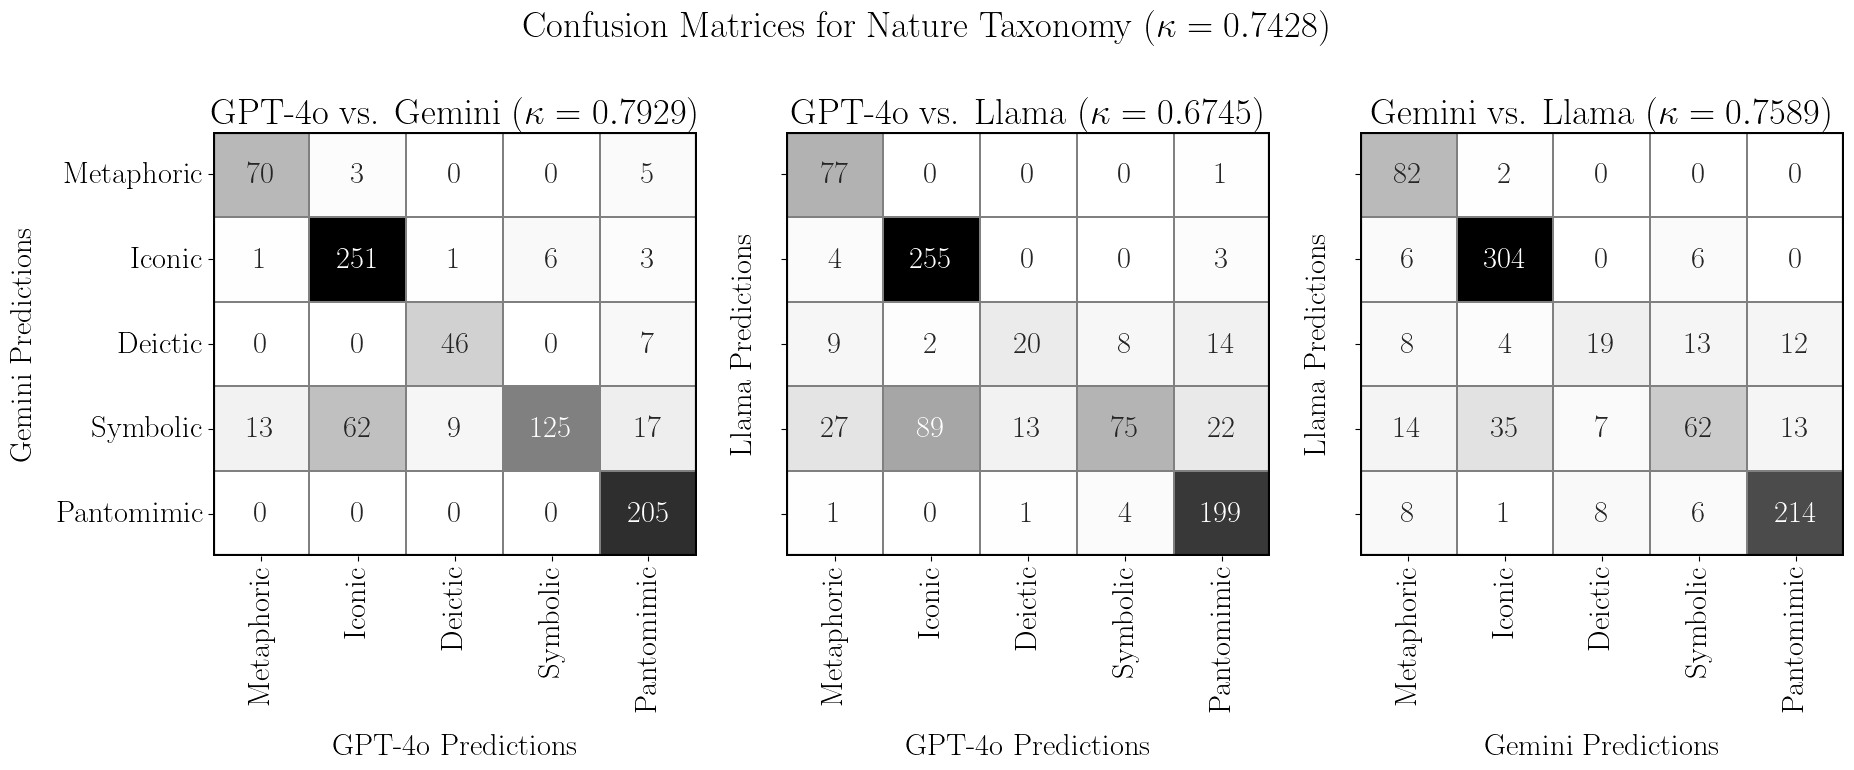

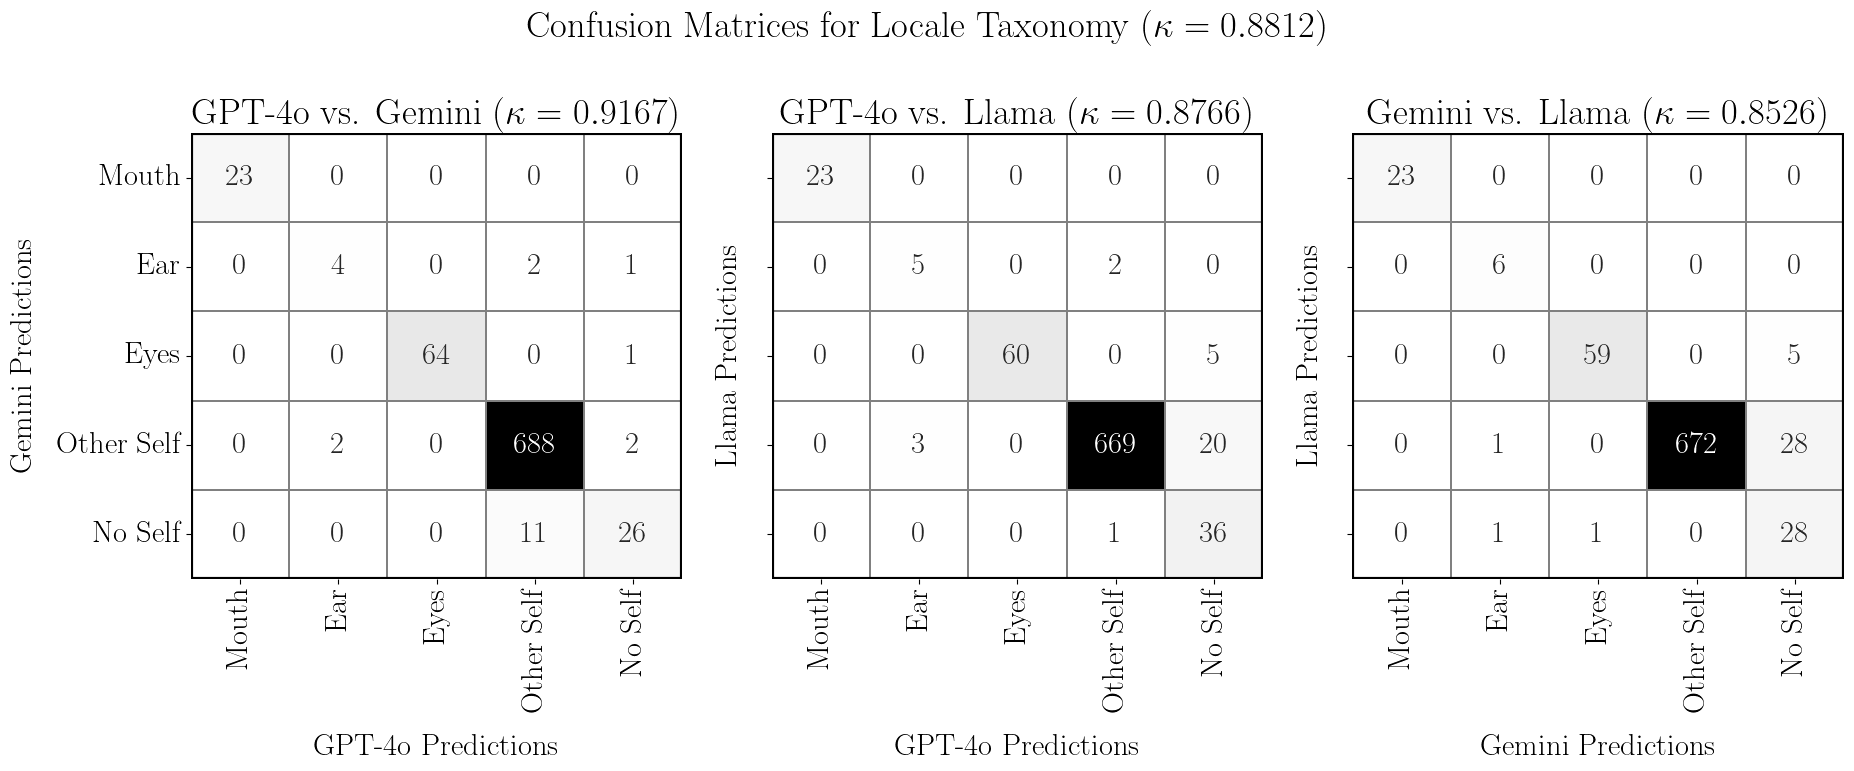

In [6]:
# Define the taxonomy classes and categories.
taxonomy_classes = [ "nature", "locale" ]
categories = [
    [ "Metaphoric", "Iconic", "Deictic", "Symbolic", "Pantomimic" ],
    [ "Mouth Interaction", "Ear Interaction", "Eyes Interaction",
      "Other Self Interaction", "No Self Interaction" ],
]

# Iterate over the different taxonomy classes.
for i, taxonomy in enumerate(taxonomy_classes):

    # Create a dictionary of dataset taxonomies.
    taxonomies = {
        model: pd.read_csv(
            f"./data/d{i*3+j+1}_{taxonomy}_classification_{model.value}.csv"
        ) for j, model in enumerate(Models)
    }

    # Melting the taxonomies and merging them into a single DataFrame.
    for (value, df_taxonomy), model in zip(taxonomies.items(), Models):
        taxonomies[value] = df_taxonomy.melt(
            id_vars="id_video", var_name="id_gesture",
            value_name=f"{model.value}-{taxonomy}"
        )

    # Merge the taxonomies into a single DataFrame.
    df_taxonomies = taxonomies[Models.OPENAI_MODEL].iloc[:, 1:]

    # Adding the last column of the other dataframes into the first dataframe.
    for model in [Models.GEMINI_MODEL, Models.LLAMA_MODEL]:
        df_taxonomies[f"{model.value}-{taxonomy}"] = \
            taxonomies[model].iloc[:, -1]

    # Find the most common values in each row.
    common_values = df_taxonomies.mode(axis=1)

    # Replace the non-consensus values with NaN.
    common_values = common_values.apply(
        lambda x: x if x.count() == 1 else np.nan, axis=1)

    # Identify the indexes where there is no consensus.
    indexes = common_values[0][common_values[0].isna()].index

    # Create a DataFrame with the common values.
    df_common_values = pd.concat((
        taxonomies[value].iloc[:, :-1], common_values[0]), axis=1)

    # Manually set the values for the indexes without consensus.
    if i == 0:
        df_common_values.iloc[indexes, 2] = [
            "Metaphoric", "Metaphoric", "Metaphoric", "Metaphoric",
            "Metaphoric", "Pantomimic", "Pantomimic", "Metaphoric",
            "Metaphoric", "Symbolic", "Symbolic", "Symbolic"
        ]

    # Unmelt the DataFrame to get the original structure.
    df_unmelted = df_common_values.pivot(
        index="id_video", columns="id_gesture", values=0).reset_index()

    # Add a new column after 'composition' class.
    for j in range(1, 9):
        df_original.insert(
            df_original.columns.get_loc(f"c{j}_composition") + 1,
            f"c{j}_{taxonomy}", df_unmelted[f"c{j}_{taxonomy}"].str.capitalize()
        )

    # Convert categorical classifications into numerical categories.
    category_mapping = { 
        category: str(j) for j, category in enumerate(categories[i])
    }

    # Apply mapping to convert text labels into numerical values
    df_numerical = df_taxonomies.iloc[:, 1:].replace(category_mapping)
    df_numerical = df_numerical.astype(int)

    # Compute Fleiss' Kappa.
    kappa = calculate_fleiss_kappa(df_numerical, len(categories[i]))
    print(f"Fleiss' Kappa ({taxonomy.capitalize()} Taxonomy): {kappa:.4f}")

    # Iterate over all possible combinations of models.
    fig, axs = plt.subplots(1, 3, figsize=(19, 8))
    plt.suptitle(
        f"Confusion Matrices for {taxonomy.capitalize()} Taxonomy "
        f"($\\kappa={kappa:.4f}$)"
    )
    for j, models in enumerate(combinations(df_taxonomies.columns[1:], 2)):

        # Create a confusion matrix for the two models.
        cm = confusion_matrix(
            df_taxonomies[models[0]],
            df_taxonomies[models[1]]
        )

        # Get the model labels.
        labels = [
            MODELS_MAP[Models[model.split('-')[0].upper() + '_MODEL']]
            for model in models
        ]

        wrapped_labels = [
            label.replace(" Interaction", "")
            for label in categories[i]
        ]

        # Compute Fleiss' Kappa.
        kappa = calculate_fleiss_kappa(
            df_numerical[[models[0], models[1]]], len(categories[i]))
        print(f"Fleiss' Kappa ({labels[0]} vs. {labels[1]}): {kappa:.4f}")

        # Plot the confusion matrix.
        if j == 0:
            hm = sns.heatmap(
                cm, annot=True, fmt="d", cmap="gray_r", ax=axs[j], cbar=False,
                xticklabels=wrapped_labels, yticklabels=wrapped_labels,
                linewidths=0.1, linecolor="gray"
            )
        else:
            hm = sns.heatmap(
                cm, annot=True, fmt="d", cmap="gray_r", ax=axs[j], cbar=False,
                xticklabels=wrapped_labels,
                yticklabels=[None] * len(wrapped_labels),
                linewidths=0.1, linecolor="gray"
            )

        # Set the plot labels.
        hm.set_xticklabels(hm.get_xticklabels(), rotation=90)
        hm.set_yticklabels(hm.get_yticklabels(), rotation=0)
        axs[j].xaxis.labelpad = 15
        axs[j].yaxis.labelpad = 14
        axs[j].set_title(f"{labels[0]} vs. {labels[1]} ($\\kappa={kappa:.4f}$)")
        axs[j].set_xlabel(f"{labels[0]} Predictions")
        axs[j].set_ylabel(f"{labels[1]} Predictions")

        axs[j].axhline(y=0, color="black",linewidth=3)
        axs[j].axhline(y=cm.shape[1], color="black",linewidth=3)
        axs[j].axvline(x=0, color="black",linewidth=3)
        axs[j].axvline(x=cm.shape[0], color="black",linewidth=3)

    plt.tight_layout()
    
    # Save the plot as a PGF file.
    plt.savefig(f"pgf/{taxonomy}_confusion_matrix.pgf")

# Save the original dataset with the new columns.
df_original.to_csv("./outputs/elicitation_dataset.csv", index=False)

This code cell aggregates and visualizes the distribution of hand gesture taxonomy classifications across four taxonomy classes: `Composition`, `Form`, `Locale`, and `Nature`. It merges all instances for each class, normalizes the frequency of each category, and creates a structured DataFrame for plotting. The resulting stacked bar chart (in grayscale) displays the proportion of each taxonomy category, providing an overview of how participants' gestures are distributed according to different classification schemes. This visualization helps identify dominant gesture types and patterns in user-defined mid-air gestures for hybrid meeting controls.

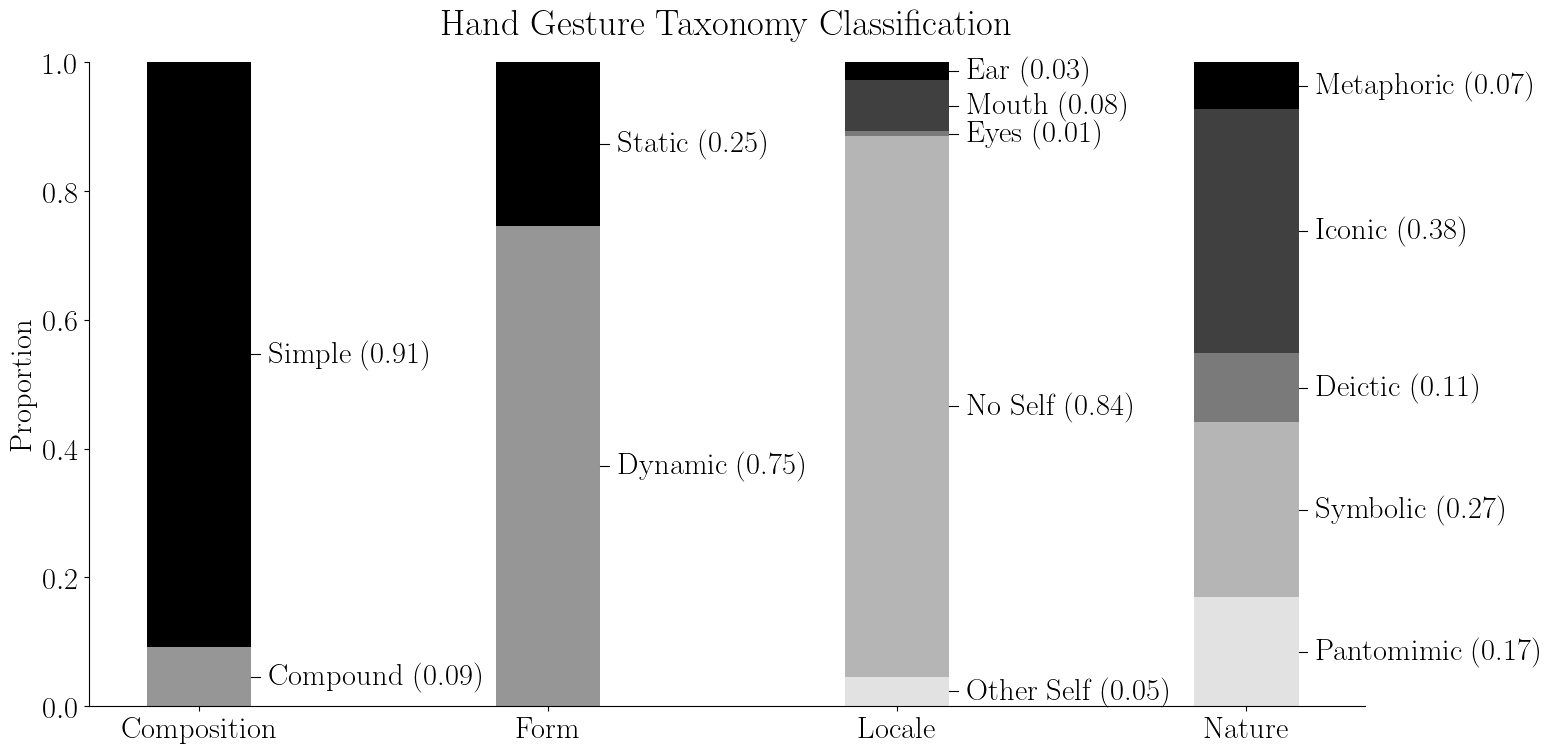

In [7]:
# Define the correct taxonomy categories and their corresponding columns.
selected_classes = {
    "Composition":
        [ col for col in df_original.columns if col.endswith("_composition") ],
    "Form":
        [ col for col in df_original.columns if col.endswith("_form") ],
    "Locale":
        [ col for col in df_original.columns if col.endswith("_locale") ],
    "Nature":
        [ col for col in df_original.columns if col.endswith("_nature") ],
}

# Combine all instances for each class into a single column.
merged_data = {}
for category, columns in selected_classes.items():
    merged_data[category] = pd.concat(
        [ df_original[col] for col in columns ], axis=0).dropna()

# Correct the "Composition" class names.
merged_data["Composition"] = merged_data["Composition"].astype(str)
merged_data["Composition"][merged_data["Composition"] != "1"] = "Compound"
merged_data["Composition"][merged_data["Composition"] == "1"] = "Simple"

# Compute normalized frequency for each category.
normalized_counts = {
    category: values.value_counts(normalize=True)
    for category, values in merged_data.items()
}

# Create a structured DataFrame for plotting.
plot_df = pd.DataFrame(normalized_counts).fillna(0).T

# Plot the stacked bar chart in grayscale with adaptive text color.
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.3
bottom = np.zeros(len(plot_df))

# Assign unique labels for each category.
unique_labels = [
    [ "Compound", "Simple" ],
    [ "Dynamic", "Static" ],
    [ "Other self interaction", "No self interaction",
      "Eyes interaction", "Mouth interaction", "Ear interaction" ],
    [ "Pantomimic", "Symbolic", "Deictic", "Iconic", "Metaphoric" ]
]

# Plot each category as a stacked bar segment.
for labels in unique_labels:

    # Create a color map for the labels.
    color_map = plt.get_cmap("Greys", len(labels) + 1)
    colors = { label: color_map(i + 1) for i, label in enumerate(labels) }

    # Plot the stacked bar segments.
    for label in labels:
        values = plot_df[label].values
        bars = ax.bar(
            plot_df.index, values, bar_width,
            label=label, bottom=bottom, color=colors[label]
        )
        bottom += values

        # Add text labels with adaptive color.
        for i, (value, category) in enumerate(zip(values, plot_df.index)):
            if value > 0.0:

                # Determine the text color based on the background color.
                bar_color = colors[label]
                ax.text(
                    i + 0.2, bottom[i] - value / 2,
                    f"{label.title().replace(" Interaction", "")} ({value:.2f})",
                    ha="left", va="center", color="black"
                )

                # Draw a pointing line from text to bar area
                ax.plot(
                    [i  + 0.15, i + 0.175], [bottom[i] - value / 2] * 2,
                    color="black", linestyle="-", linewidth=0.8
                )

# Set the plot properties.
ax.set_ylim(0, 1)
ax.set_ylabel("Proportion")
ax.set_title(
    "Hand Gesture Taxonomy Classification", pad=20)
ax.set_xticks(np.arange(len(plot_df.index)))
ax.legend([], [], frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()

# Save the plot as a PGF file.
plt.savefig("pgf/taxonomy_proportion.pgf")

This code cell calculates the agreement rate for each gesture command and the overall agreement rate among participants. Using the `compute_agreement_rate()` function and the `gesture_counts` DataFrame, it quantifies how consistently participants selected the same gestures for each command. The results are printed for each command and overall, providing insight into the level of consensus in gesture selection across the dataset.

In [ ]:
def report_agreement_rates(df_counts: pd.DataFrame, label: str) -> None:
    """
    Compute and print agreement rates for each command and the overall rate.

    Args:
        df_counts (pd.DataFrame): Gesture counts dataframe.
        label (str): Label to describe the participant group (e.g., 'General').
    """
    agreement_rates = compute_agreement_rate(df_counts)
    print(f"\nAgreement Rates ({label}):")
    for cmd, ar in agreement_rates.items():
        print(f"{cmd}: {ar:.4f}")


# Report agreement rates for all participants.
report_agreement_rates(gesture_counts, "General")



Agreement Rates (General):
c1_command: 0.1755
c2_command: 0.1599
c3_command: 0.0879
c4_command: 0.0712
c5_command: 0.0518
c6_command: 0.0487
c7_command: 0.3113
c8_command: 0.0731
overall: 0.1239


In [10]:
# Report agreement rates for participants with hand gesture experience.
report_agreement_rates(gesture_counts_no_hg_exp, "No HG Experience")


Agreement Rates (No HG Experience):
c1_command: 0.1808
c2_command: 0.1174
c3_command: 0.1026
c4_command: 0.1215
c5_command: 0.0310
c6_command: 0.0499
c7_command: 0.2524
c8_command: 0.0540
overall: 0.1222


In [11]:
# Report agreement rates for participants with hand gesture experience.
report_agreement_rates(gesture_counts_hg_exp, "HG Experience")


Agreement Rates (HG Experience):
c1_command: 0.1706
c2_command: 0.1880
c3_command: 0.0759
c4_command: 0.0521
c5_command: 0.0675
c6_command: 0.0471
c7_command: 0.3631
c8_command: 0.0809
overall: 0.1233


This code cell evaluates the use of opposite gestures for paired commands in the elicitation dataset. For each of the first three command pairs (e.g., Increase/Decrease Volume), it checks whether participants used gestures that are defined as opposites in the provided mapping. The code calculates and prints the percentage of participants who used opposite gestures for each pair, and performs a chi-square test to determine if the observed use of opposites differs significantly from chance. The results provide insight into the consistency and intuitiveness of gesture oppositeness in user-defined controls.

In [12]:
# Generate a map with the opposite gestures.
opposite_gestures_map = dict(
    zip(df_opposite_gestures["gesture1"], df_opposite_gestures["gesture2"])
)

# Evaluate the opposite gestures for the first three pairs of commands.
for i in range(1, 4):

    # Verify the opposite gestures.
    is_opposite = df_original.apply(lambda row: are_gestures_opposite(
        row[f"c{2 * i - 1}_command"], row[f"c{2 * i}_command"],
        opposite_gestures_map
    ), axis=1)

    # Calculate the percentage of participants that used opposite gestures.
    percentage_opposite = is_opposite.mean() * 100
    print("\nPercentage of participants that used opposite gestures: "
          f"{percentage_opposite:.2f}%.")

    # Observed values for the chi-square test.
    opposite_count = is_opposite.sum()
    non_opposite_count = len(df_original) - opposite_count
    observed = np.array([[opposite_count, non_opposite_count]])

    # Expected values for the chi-square test.
    expected = np.array([[len(df_original) / 2, len(df_original) / 2]])

    # Calculate the chi-square test.
    chi2_stat = np.sum((observed - expected) ** 2 / expected)

    # Calculate the p-value.
    p_value = chi2.sf(chi2_stat, df=1)

    # Show the chi-square test results.
    print(f"Chi²: {chi2_stat:.3f}")
    print(f"P-value: {p_value:.4f}")


Percentage of participants that used opposite gestures: 45.63%.
Chi²: 0.786
P-value: 0.3752

Percentage of participants that used opposite gestures: 30.10%.
Chi²: 16.320
P-value: 0.0001

Percentage of participants that used opposite gestures: 20.39%.
Chi²: 36.126
P-value: 0.0000


This code cell examines the proportion of participants who selected specific pairs of gestures for related command pairs. It calculates the percentage of users who chose both `palm up` for the increase volume command (`c1_command`) and `palm down` for the decrease volume command (`c2_command`), as well as those who chose both `hand grab` for mute (`c3_command`) and `hand release` for unmute (`c4_command`). These proportions provide insight into the consistency and intuitiveness of user-defined gesture opposites for paired actions in the dataset.

In [14]:
# Calculate the proportion of participants who chose both "Palm up" for
# `c1_command` and "Palm down" for `c2_command`.
both_conditions_count = df_original[
    (df_original["c1_command"] == "Palm up") &
    (df_original["c2_command"] == "Palm down")].shape[0]
sample_participants = df_original[
    (df_original["c1_command"] == "Palm up")].shape[0]

# Calculate the proportion.
both_conditions_proportion = both_conditions_count / sample_participants

# Display the result.
print("\nProportion of participants who chose both 'Palm up' for "
      "`c1_command` and 'Palm down' for `c2_command`: "
      f"{both_conditions_proportion:.2f}")

# Calculate the proportion of participants who chose both "Hand grab" for
# `c3_command` and "Hand release" for `c4_command`.
both_conditions_count = df_original[
    (df_original["c3_command"] == "Hand grab") &
    (df_original["c4_command"] == "Hand release")].shape[0]
sample_participants = df_original[
    (df_original["c3_command"] == "Hand grab")].shape[0]

# Calculate the proportion.
both_conditions_proportion = both_conditions_count / sample_participants

# Display the result.
print("\nProportion of participants who chose both 'Hand grab' for "
      "`c3_command` and 'Hand release' for `c4_command`: "
      f"{both_conditions_proportion:.2f}")


Proportion of participants who chose both 'Palm up' for `c1_command` and 'Palm down' for `c2_command`: 0.75

Proportion of participants who chose both 'Hand grab' for `c3_command` and 'Hand release' for `c4_command`: 0.69


This code cell computes the Dissimilarity-Consensus (CR(t)) for each gesture command using gesture embedding data and a Dynamic Time Warping (DTW) threshold. The function `compute_dissimilarity_consensus()` quantifies how similar or dissimilar the gesture embeddings are within each command, providing a percentage score for consensus. The results are printed for each command, offering insight into the variability and agreement of gesture performance among participants.

In [15]:
# Calculate the Dissimilarity-Consensus CR(t) for an initial threshold of 5.0.
cr_results = compute_dissimilarity_consensus(df_hand_gestures, threshold=5)

# Prepare the data for plotting.
# commands = list(cr_results.keys())
commands = [
    f"$R_{i}$ {GESTURES_MAP[gesture]}" for i, gesture in enumerate(Gesture) ]  
cr_values = list(cr_results.values())

# Print the computed Dissimilarity-Consensus.
for cmd, cr in cr_results.items():
    print(f"{cmd}: {cr:.2f}%")

c1_description: 10.49%
c2_description: 12.93%
c3_description: 5.84%
c4_description: 5.27%
c5_description: 2.42%
c6_description: 3.43%
c7_description: 30.86%
c8_description: 4.28%


This code cell visualizes the Dissimilarity-Consensus (CR(t)) scores for each gesture command using a horizontal bar plot. Each bar represents the percentage of consensus (similarity) among participants' gesture embeddings for a specific command, as computed by Dynamic Time Warping. The plot includes value annotations for clarity and is formatted for publication-quality output. This visualization helps to quickly compare the degree of consensus across different gesture commands in the dataset.

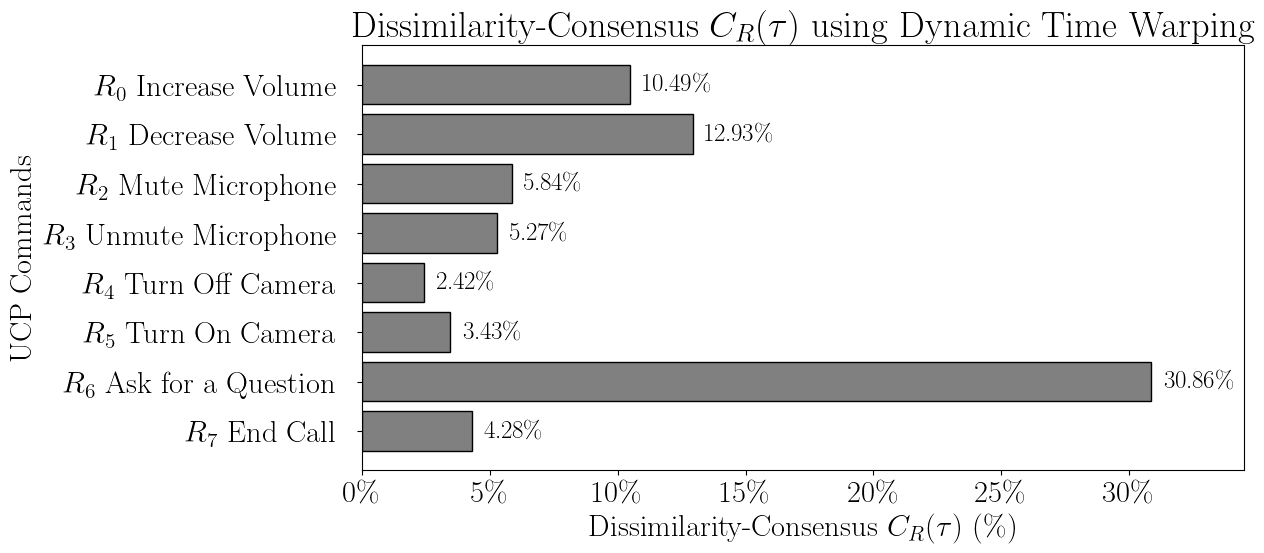

In [16]:
# Create a bar plot to visualize the Dissimilarity-Consensus (Cosine
# Similarity).
plt.figure(figsize=(13, 6))
plt.barh(commands, cr_values, color="gray", edgecolor="black")

# Add values on top of the bars.
for index, value in enumerate(cr_values):
    plt.text(
        value + 0.5, index, f"{value:.2f}\\%", va="center", ha="left",
        fontsize=18
    )

# Set the plot properties.
plt.title("Dissimilarity-Consensus $C_R(\\tau)$ using Dynamic Time Warping")
plt.xlabel("Dissimilarity-Consensus $C_R(\\tau)$ (\\%)")
plt.ylabel("UCP Commands")
plt.gca().yaxis.set_tick_params(pad=15)
plt.xlim(0, 34.5)
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"{x:.0f}\\%")
)
plt.gca().invert_yaxis()
plt.tight_layout()

# Save the plot as a PGF file.
plt.savefig("pgf/dissimilarity_consensus.pgf")


This code prepares the data for dimensionality reduction and visualization of gesture embeddings:

- The gesture command dataframe is `melted` to convert it from wide to long format, resulting in a table where each row represents a single gesture command instance for a participant.
- Gesture embeddings are extracted and stacked into a NumPy array, and the corresponding command labels are collected.
- Linear Discriminant Analysis (LDA) is performed to project the high-dimensional gesture embeddings into a 2D space, using the command labels as class information. This enables visualization of how gesture representations cluster according to command categories.

In [17]:
# Melt the dataframe with gesture commands.
df_commands_melted = df_commands.melt(
    id_vars="id_video", var_name="id_command", value_name=f"command"
)

# Get the values to be used in the LDA.
embeddings = np.stack(df_hand_gestures["embedding"].values)
commands = df_commands_melted["command"]

# Perform the LDA.
lda = LDA(n_components=2)
lda_2d = lda.fit_transform(embeddings, commands)

This code cell prepares the data for visualizing the distribution of gesture embeddings in a reduced two-dimensional space. It organizes the LDA-transformed coordinates and the most common gesture labels for each command, adds random jitter for better separation in the plot, and structures the data for subsequent visualization. This enables clear comparison of gesture clusters and label frequencies across different commands.

In [18]:
# Create a dictionary to store the data for each command.
data_2d = { i: {"data": [], "label": []} for i in range(8) }

# Iterate over the commands to store the data.
np.random.seed(42)
for i in range(8):

    # Get the coordinates and labels for the current command.
    coordinates = lda_2d[i * 103:(i + 1) * 103]
    labels = commands[i * 103:(i + 1) * 103]

    # Get the top 5 most common labels.
    label_counts = pd.Series(labels).value_counts().sort_values(ascending=False)
    for label in label_counts.index[:5]:
        coordinates_2D = coordinates[labels == label]
        if (coordinates_2D.shape[0] == 0):
            continue

        # Add jitter to the coordinates.
        x_jitter = coordinates_2D[:, 0] + \
            np.random.normal(0, 0.5, len(coordinates_2D[:, 0]))
        y_jitter = coordinates_2D[:, 1] + \
            np.random.normal(0, 0.5, len(coordinates_2D[:, 1]))

        # Store the data.
        data_2d[i]["data"].append((x_jitter, y_jitter))
        data_2d[i]["label"].append((label))

This code cell performs dimensionality reduction and visualization of gesture embeddings using Linear Discriminant Analysis (LDA). It projects high-dimensional gesture data into a two-dimensional space, groups the embeddings by command, and removes duplicate coordinates for clarity. The resulting 2D data structure is prepared for plotting, enabling visual comparison of gesture clusters and their distribution across different command categories.

In [19]:
# Get the values to be used in the LDA.
embeddings = np.stack(df_hand_gestures["embedding"].values)
id_commands = df_commands_melted["id_command"]

# Perform the LDA.
lda = LDA(n_components=2)
lda_2d = lda.fit_transform(embeddings, id_commands)

This code cell organizes the LDA-reduced gesture embedding data for each command, removing duplicate coordinates to highlight unique gesture representations. For each command, it collects the 2D coordinates and corresponding labels, preparing the data structure for clear and uncluttered visualization of gesture clusters in the subsequent plot.

In [20]:
# Create a dictionary to store the data for each command.
embeddings_2d = { i: {"data": [], "label": []} for i in range(8) }

# Iterate over the commands to store the data.
for i in range(8):

    # Get the coordinates and labels for the current command.
    coordinates = lda_2d[i * 103:(i + 1) * 103]
    labels = id_commands[i * 103:(i + 1) * 103]

    # Remove duplicated 2D coordinates.
    coordinates = np.round(coordinates, decimals=5)
    coordinates = np.unique(coordinates, axis=0)

    # Get the coordinates.
    x_coordinates = coordinates[:, 0]
    y_coordinates = coordinates[:, 1]

    # Store the data.
    embeddings_2d[i]["data"].append((x_coordinates, y_coordinates))
    embeddings_2d[i]["label"].append(labels.values[0])

This code cell visualizes the results of the LDA-based dimensionality reduction of gesture embeddings. It creates scatter plots for each command, showing how the five most common hand gesture descriptions cluster in the 2D LDA space. Each subplot corresponds to a specific command, with different markers and grayscale colors representing distinct gesture labels. The final subplot aggregates all commands, enabling comparison of gesture distributions and highlighting the diversity and overlap of user-defined gestures across referents. This visualization provides insight into the separability and clustering of gesture types for hybrid meeting platform controls.

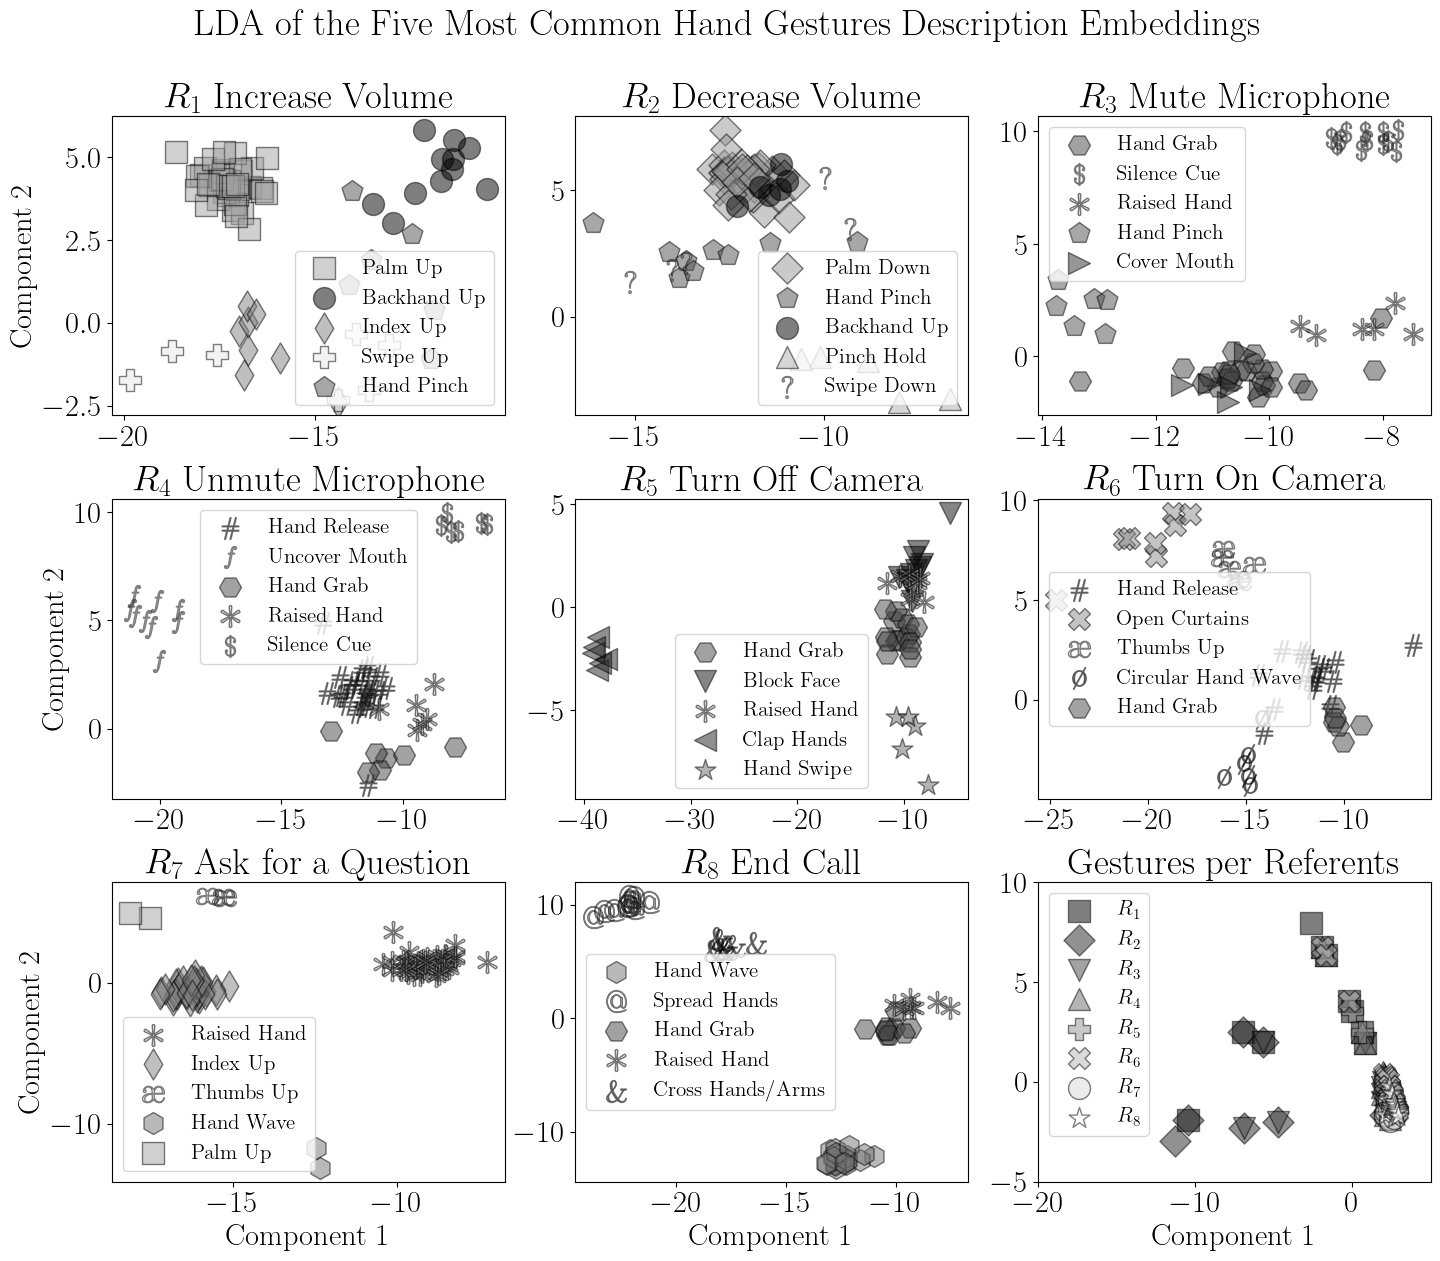

In [21]:
# Plot the result.
fig, axes = plt.subplots(3, 3, figsize=(15, 13))
axes = axes.flatten()

# Get all labels and generate a list of unique labels.
all_labels = []
for i in range(8):
    all_labels.extend(data_2d[i]["label"])
unique_labels = np.unique(all_labels)

# Create a color map and markers for the labels.
colors = plt.get_cmap("gray", len(unique_labels))
markers = [
    'o', 'v', '$ø$', '<', '>', '$\\&$', 'H', 'p', '$\\#$', '*', 'h', 'd', 'X',
    'D', 's', '^', '$*$', '$\\$$', '$@$', '$?$', 'P', '$æ$', '$f$'
]

r_colors = plt.get_cmap("gray", 8)
r_markers = [
    's', 'D', 'v', '^', 'P', 'X', 'o', '*'
]

# Plot the data for each command.
for i in range(8):

    # Get the coordinates and labels for the current command.
    coordinates = data_2d[i]["data"]
    labels = data_2d[i]["label"]

    # Plot the data.
    for coordinate, label in zip(coordinates, labels):

        # Get the jittered coordinates, color, and marker.
        x_jitter, y_jitter = coordinate
        color = colors(unique_labels.tolist().index(label))
        marker = markers[unique_labels.tolist().index(label)]

        # Plot the scatter plot.
        axes[i].scatter(
            x_jitter, y_jitter, alpha=0.5, color=color, label=label.title(),
            edgecolor="black", s=250, marker=marker)

        # Set the plot properties.
        axes[i].legend(
            loc="best", shadow=False, scatterpoints=1, fontsize="x-small")
        axes[i].set_title(
            f"$R_{i + 1}$ {GESTURES_MAP[Gesture(command_columns[i + 1])]}"
        )
        if i > 5:
            axes[i].set_xlabel("Component 1")
        if i % 3 == 0:
            axes[i].set_ylabel("Component 2")

    # Get the coordinates and labels for the current embeddings.
    coordinates = embeddings_2d[i]["data"][0]
    label = f"$R_{i + 1}$"

    # Get the jittered coordinates, color, and marker.
    x_jitter, y_jitter = coordinates
    color = r_colors(i)
    marker = r_markers[i]

    axes[8].scatter(
        x_jitter, y_jitter, alpha=0.5, edgecolor="black", label=label.title(),
        facecolor=color, s=250, marker=marker)

# Set subplot 9 properties.
axes[8].set_title("Gestures per Referents")
axes[8].set_xlabel("Component 1")
axes[8].legend(
    loc="best", shadow=False, scatterpoints=1, fontsize="x-small")
axes[8].set_xlim(-20, 5)
axes[8].set_ylim(-5, 10)

# Set the plot properties.
plt.suptitle("LDA of the Five Most Common Hand Gestures Description Embeddings")
plt.tight_layout()
plt.subplots_adjust(wspace=0.18, hspace=0.28)

# Save the plot as a PGF file.
plt.savefig("pgf/lda.pgf")

## End of Notebook

This concludes the analysis and visualization of user-defined mid-air hand gestures for hybrid meeting platform control. The notebook provided:

- **Data loading, preprocessing, and taxonomy classification** for gesture commands.
- **Statistical analyses** including agreement rates, oppositeness, and consensus metrics.
- **Dimensionality reduction and visualization** of gesture embeddings to reveal clustering and diversity.
- **Comprehensive documentation** of workflow, variables, and results for reproducibility.

**Important Information:**
- All code, data, and outputs are organized for transparency and further exploration.
- Variable summaries and intermediate results are available for reference.
- For questions or extensions, please refer to the original paper or contact the authors.

Thank you for using this notebook!